## Run LAS

In [1]:
#Build Molecule
import numpy as np
from pyscf import gto, scf, lib, mcscf
import math
import time
import os
from tools import sign_control, util
from systems.ethchain import EthChain_CT

geom = EthChain_CT(8,charge=-1,dist=2.5,c_dist=1.4,fn="logs/ethylene_chain_ct.log")
las = geom.make_las_state_average()

#Build LAS states
print("Initiating LAS Model Space...")
start = time.perf_counter()
las.lasci_()
las.ci = sign_control.fix_sign(las)
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")
las.dump_spaces()

#Run LASSI
print("Running LASSI...")
start = time.perf_counter()
from mrh.my_pyscf import lassi
lsi = lassi.LASSI(las)
energies_lassi, civecs_lassi = lsi.kernel()
civecs_lassi = lsi.get_sivec_vacuum_shuffle(state=0)
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")

/home/king1305/Apps/pyscf/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


overwrite output file: logs/ethylene_chain_ct.log
Initiating LAS Model Space...
Done. Time elapsed: 8.418703552000807 seconds
Running LASSI...
Done. Time elapsed: 1.9434631039985106 seconds


## Plotting

[-620.53 -620.25 -620.23 -620.22 -620.23 -620.23 -620.22 -620.23 -620.25]


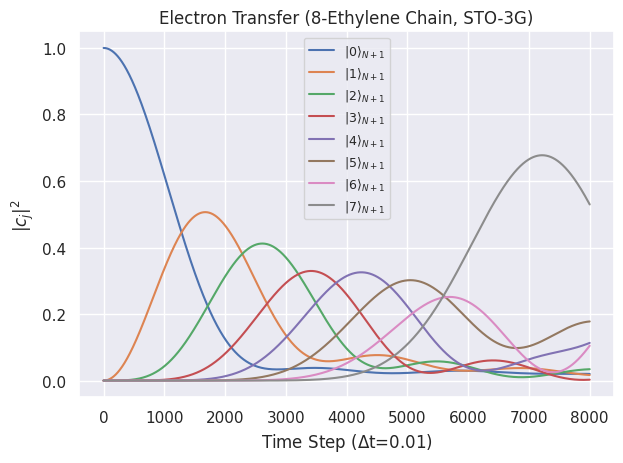

In [7]:
from scipy import linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tools.bandh import make_h
sns.set()

def evolve(H,t=10000,deltat=0.01,startin=1):
    c0 = np.eye(H.shape[0])[:,startin]
    cs = [c0]
    c = c0
    tstep = 0.01
    for i in range(t):
        U = linalg.expm(-(1j)*tstep*H) #evolution
        c = U @ c
        cs += [c]
    cs = np.vstack(cs)
    assert(np.allclose(np.real((cs*cs.conj()).sum(axis=1)),np.ones(cs.shape[0])))
    return cs

def c_to_charges(c,las_charges):
    p = np.real(c * c.conj())
    assert(np.allclose(p.sum(),1,atol=1e-4))
    charges = las_charges #cut out gs
    charges = (charges * p[:,None]).sum(axis=0)
    return charges

H = make_h(civecs_lassi,energies_lassi,plot=False)
cs = evolve(H,t=8000)
cs2 = cs * cs.conj()

df = pd.DataFrame(cs2[:,1:]) #cut out ground state
for col in df.columns:
    x = df.index
    y = np.real(df[col])
    plt.plot(x,y,label = f"|{col}⟩" + "$_{N+1}$")
plt.legend(loc="upper center",ncols=1,fontsize=9)
plt.xlabel("Time Step ($\Delta$t=0.01)")
plt.ylabel("$|c_j|^2$")
plt.title("Electron Transfer (8-Ethylene Chain, STO-3G)")
plt.tight_layout()
plt.savefig("figures/ethylenect_electron_coeff.png",dpi=500)

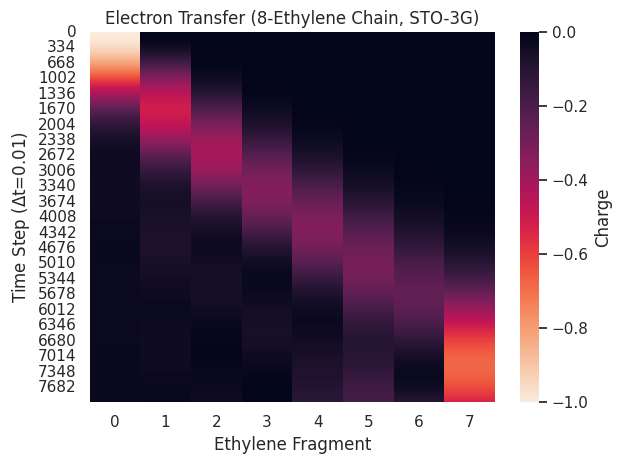

In [3]:
charges_all = []
las_charges = util.las_charges(las)
for c in cs:
    charges = c_to_charges(c,las_charges)
    charges_all += [charges]
charges = np.vstack(charges_all)
sns.heatmap(charges,cmap="rocket_r",cbar_kws={'label': 'Charge'})
plt.ylabel("Time Step ($\Delta$t=0.01)")
plt.xlabel("Ethylene Fragment")
plt.title("Electron Transfer (8-Ethylene Chain, STO-3G)")
plt.tight_layout()
plt.savefig("figures/ethylenect_electron_charge.png",dpi=500)

[-620.53 -620.25 -620.23 -620.22 -620.23 -620.23 -620.22 -620.23 -620.25]


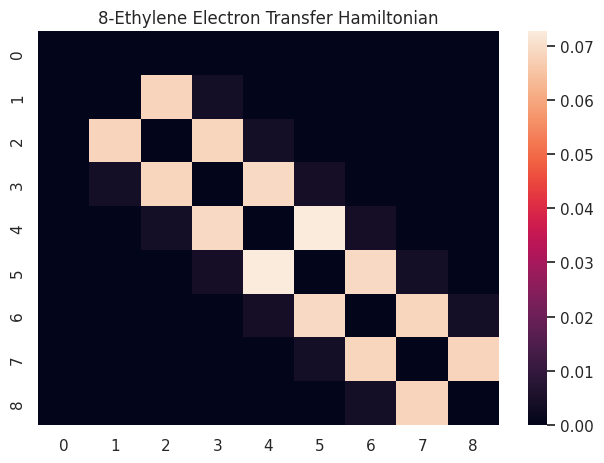

In [5]:
H = make_h(civecs_lassi,energies_lassi,plot=False)
H = H - np.diag(np.diag(H))
sns.heatmap(H)
plt.title("8-Ethylene Electron Transfer Hamiltonian")
plt.tight_layout()
plt.savefig("figures/electronct_hamiltonian_nodiag.png",dpi=500)

[-620.53 -620.25 -620.23 -620.22 -620.23 -620.23 -620.22 -620.23 -620.25]


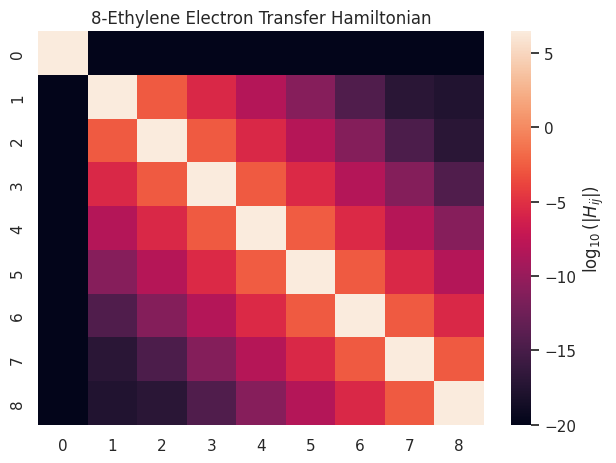

In [6]:
H = make_h(civecs_lassi,energies_lassi,plot=False)
for i in range(H.shape[0]):
    H[i][np.where(H[i] != 0)] = np.log(np.abs(H[i][np.where(H[i] != 0)]))
    H[i][np.where(H[i] == 0)] = -20
sns.heatmap(H,cbar_kws={'label': "$\log_{10}(|H_{ij}|)$"})
plt.title("8-Ethylene Electron Transfer Hamiltonian")
plt.tight_layout()
plt.savefig("figures/electronct_hamiltonian_log.png",dpi=500)

In [ ]:
Transfer Hamiltonian")
plt.tight_layout()
plt.savefig("figures/ct_hamiltonian_log.png",dpi=500)